In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from datetime import datetime 
pd.options.mode.chained_assignment = 'warn'  # default='warn'

In [25]:
scaler = StandardScaler(with_std=True, with_mean=True)

def filter_pca_data(df: pd.DataFrame, dropped_depths: list[int] = []):
    dropped_features = [
        'Unnamed: 0',
        'TIMESTAMP',
        'RECORD',
        'TIMESTAMP_DIFF',
        'Redox_error_flag_available',
        'log_redox(1)',
        'log_redox(2)',
        'log_redox(3)',
        'log_redox(4)',
        'log_redox(5)',
        'neg_log(1)',
        'neg_log(2)',
        'neg_log(3)',
        'neg_log(4)',
        'neg_log(5)',
        'Temp_T21_Avg(1)',
        'Temp_T21_Avg(2)',
        'Temp_T21_Avg(3)',
        'Temp_T21_Avg(4)',
        'Temp_T21_Avg(5)',
        'Redox_error_flag',
        'Redox_error_flag(1)',
        'Redox_error_flag(2)',
        'Redox_error_flag(3)',
        'Redox_error_flag(4)',
        'Redox_error_flag(5)',
        'CCVWC_Avg(1)',
        'CCVWC_Avg(2)',
        'CCVWC_Avg(3)',
        'CCVWC_Avg(4)',
        'CCVWC_Avg(5)',
        'shf_plate_Avg',
        'shf_multiplier',
        'shf_htr_resstnc',
        'shfp_wrnng_flg',
        'btt_wrnng_flg',
        'BatterymV_Min',
        'pit_number',
        # 'Redox_Avg(1)_sigma_b_12',
        # 'Redox_Avg(1)_sigma_f_12',
        # 'Redox_Avg(2)_sigma_b_12',
        # 'Redox_Avg(2)_sigma_f_12',
        # 'Redox_Avg(3)_sigma_b_12',
        # 'Redox_Avg(3)_sigma_f_12',
        # 'Redox_Avg(4)_sigma_b_12',
        # 'Redox_Avg(4)_sigma_f_12',
        # 'Redox_Avg(5)_sigma_b_12',
        # 'Redox_Avg(5)_sigma_f_12',
        # 'Redox_Avg(1)_sigma_b_24',
        # 'Redox_Avg(1)_sigma_f_24',
        # 'Redox_Avg(2)_sigma_b_24',
        # 'Redox_Avg(2)_sigma_f_24',
        # 'Redox_Avg(3)_sigma_b_24',
        # 'Redox_Avg(3)_sigma_f_24',
        # 'Redox_Avg(4)_sigma_b_24',
        # 'Redox_Avg(4)_sigma_f_24',
        # 'Redox_Avg(5)_sigma_b_24',
        # 'Redox_Avg(5)_sigma_f_24',
    ]
    for d in dropped_depths:
        dropped_features.extend([
            f'Redox_Avg({d})',
            f'EC_Avg({d})',
            f'Temp_T12_Avg({d})',
            f'Matric_potential_Avg({d})',
            f'WC{d}',
            f'Redox_Avg({d})_sigma_f'
            f'Redox_Avg({d})_sigma_b'
        ])
    pca_data = df.loc[:, ~df.columns.isin(dropped_features)]
    return pca_data

def get_pca_scores(pca_data, n_components):
    scaled = scaler.fit_transform(pca_data)
    pca = PCA(n_components)
    return pca.fit_transform(scaled)

def gmix(data, n_components, random_state):
    model = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state).fit(data)
    scores = model.score_samples(data)
    return model.predict(data), scores

def pca_gmix(pca_scores, full_data, n_clusters, outliers_fraction, random_state):
    scaled_pca_scores = scaler.fit_transform(pca_scores)
    data = pd.DataFrame(scaled_pca_scores)

    clusters, scores = gmix(data, n_clusters, random_state)
    outlier_num = int(outliers_fraction * len(scores))
    idx = np.argpartition(scores, outlier_num)
    threshold = scores[idx[:outlier_num]].max()
    is_anomaly = (scores <= threshold)
    full_data = full_data.assign(cluster=clusters, anomaly=is_anomaly)
    return full_data

def get_acc_metric_dfs(df: pd.DataFrame):
    # true_positives = df.query('(`Redox_error_flag(1)` == True | `Redox_error_flag(2)` == True | `Redox_error_flag(3)` == True | `Redox_error_flag(4)` == True | `Redox_error_flag(5)` == True) & (anomaly == True)')
    # false_positives = df.query('(`Redox_error_flag(1)` == False & `Redox_error_flag(2)` == False & `Redox_error_flag(3)` == False & `Redox_error_flag(4)` == False & `Redox_error_flag(5)` == False) & (anomaly == True)')
    true_positives = df[((df['Redox_error_flag(1)'] == True) | (df['Redox_error_flag(2)'] == True) | (df['Redox_error_flag(3)'] == True) | (df['Redox_error_flag(4)'] == True) | (df['Redox_error_flag(5)'] == True)) & (df['anomaly'] == True)]
    false_positives = df[((df['Redox_error_flag(1)'] == False) & (df['Redox_error_flag(2)'] == False) & (df['Redox_error_flag(3)'] == False) & (df['Redox_error_flag(4)'] == False) & (df['Redox_error_flag(5)'] == False)) & (df['anomaly'] == True)]
    true_negatives = df[((df['Redox_error_flag(1)'] == False) & (df['Redox_error_flag(2)'] == False) & (df['Redox_error_flag(3)'] == False) & (df['Redox_error_flag(4)'] == False) & (df['Redox_error_flag(5)'] == False)) & (df['anomaly'] == False)]
    false_negatives = df[((df['Redox_error_flag(1)'] == True) | (df['Redox_error_flag(2)'] == True) | (df['Redox_error_flag(3)'] == True) | (df['Redox_error_flag(4)'] == True) | (df['Redox_error_flag(5)'] == True)) & (df['anomaly'] == False)]
    return (true_positives, true_negatives, false_positives, false_negatives)

def get_ind_depth_acc_metric_dfs(df: pd.DataFrame, pit: int):
    # true_positives = df.query('(`Redox_error_flag(1)` == True | `Redox_error_flag(2)` == True | `Redox_error_flag(3)` == True | `Redox_error_flag(4)` == True | `Redox_error_flag(5)` == True) & (anomaly == True)')
    # false_positives = df.query('(`Redox_error_flag(1)` == False & `Redox_error_flag(2)` == False & `Redox_error_flag(3)` == False & `Redox_error_flag(4)` == False & `Redox_error_flag(5)` == False) & (anomaly == True)')
    true_positives = df[(df[f'Redox_error_flag({pit})'] == True) & (df['anomaly'] == True)]
    false_positives = df[(df[f'Redox_error_flag({pit})'] == False) & (df['anomaly'] == True)]
    true_negatives = df[(df[f'Redox_error_flag({pit})'] == False) & (df['anomaly'] == False)]
    false_negatives = df[(df[f'Redox_error_flag({pit})'] == True) & (df['anomaly'] == False)]
    return (true_positives, true_negatives, false_positives, false_negatives)

def get_acc_metrics(acc_metric_dfs: tuple[pd.DataFrame]):
    true_positives, true_negatives, false_positives, false_negatives = acc_metric_dfs
    acc = (true_positives.shape[0] + true_negatives.shape[0]) / (true_positives.shape[0] + true_negatives.shape[0] + false_positives.shape[0] + false_negatives.shape[0])
    prec = true_positives.shape[0] / (true_positives.shape[0] + false_positives.shape[0])
    rec = true_positives.shape[0] / (true_positives.shape[0] + false_negatives.shape[0])
    return (acc, prec, rec)

def add_fluctuation_peaks(df: pd.DataFrame, threshold: int = 40):
    for d in range(1,6):
        redox_avgs = df[[f'Redox_Avg({d})']]
        plus = redox_avgs - redox_avgs.shift(1)
        minus = redox_avgs - redox_avgs.shift(-1)
        df.loc[:,f'Redox_Avg_Fluctuation({d})'] = (((plus > threshold) & (minus > threshold)) | ((plus < -threshold) & (minus < -threshold))).to_numpy()
    
    return df

# def compare_shifted(anomalys):
#     shifted = (anomalys.shift(-1) | anomalys.shift(1))
#     return (anomalys | shifted)

In [13]:
all_training_data = pd.read_csv('../../Data/Training/Raw_training_data_full.csv', parse_dates=['TIMESTAMP'])
all_training_data = add_fluctuation_peaks(all_training_data)
training_data_2022 = all_training_data.loc[all_training_data['TIMESTAMP'] < datetime(2023, 1,1, 0, 0, 0), :]
training_data_2023 = all_training_data.loc[all_training_data['TIMESTAMP'] >= datetime(2023, 1,1, 0, 0, 0), :]

/tmp/ipykernel_6031/1025879952.py:1: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  all_training_data = pd.read_csv('../../Data/Training/Raw_training_data_full.csv', parse_dates=['TIMESTAMP'])


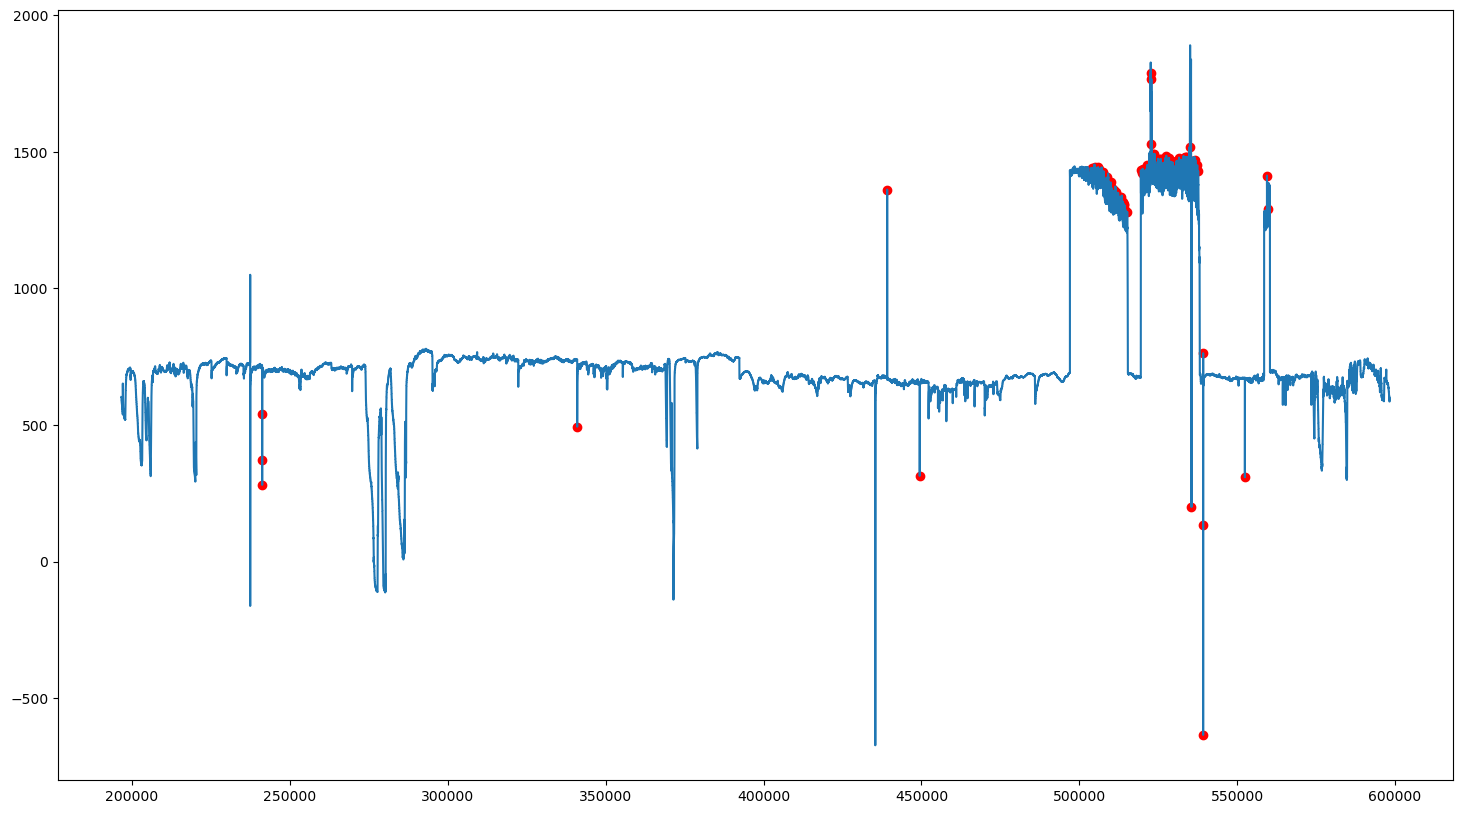

In [27]:
df = add_fluctuation_peaks(training_data_2023, 40)
d = 1
plt.figure(figsize=(18,10))
plt.plot(df[f'Redox_Avg({d})'])
plt.scatter(df[df[f'Redox_Avg_Fluctuation({d})'] == True].index, df[df[f'Redox_Avg_Fluctuation({d})'] == True][f'Redox_Avg({d})'], c='red')

## 2022 full data

Components: 5, clusters: 3, acc: 0.7496350624844234, precision: 0.6704653240772561, recall: 0.6588720027017899


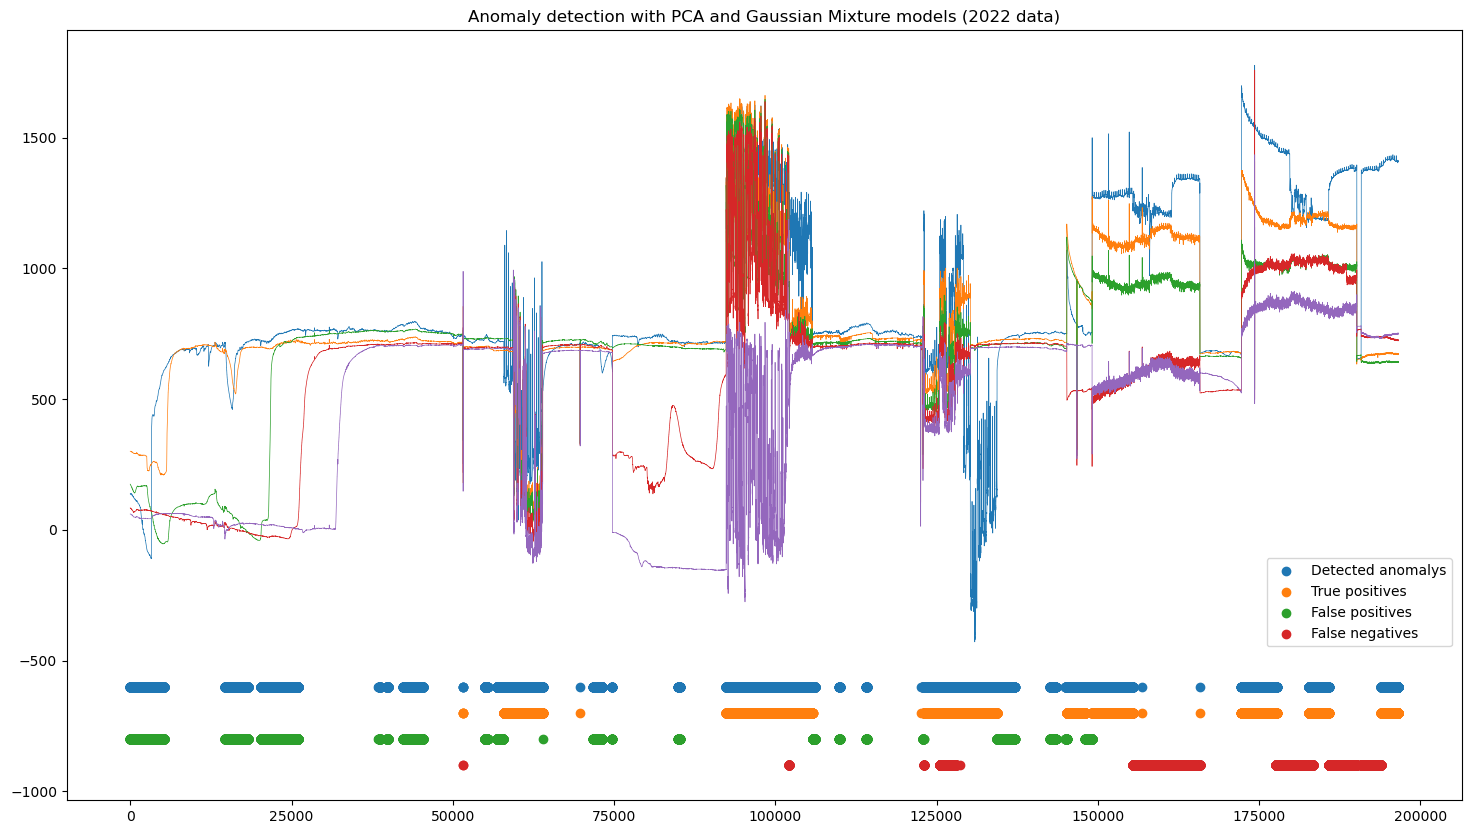

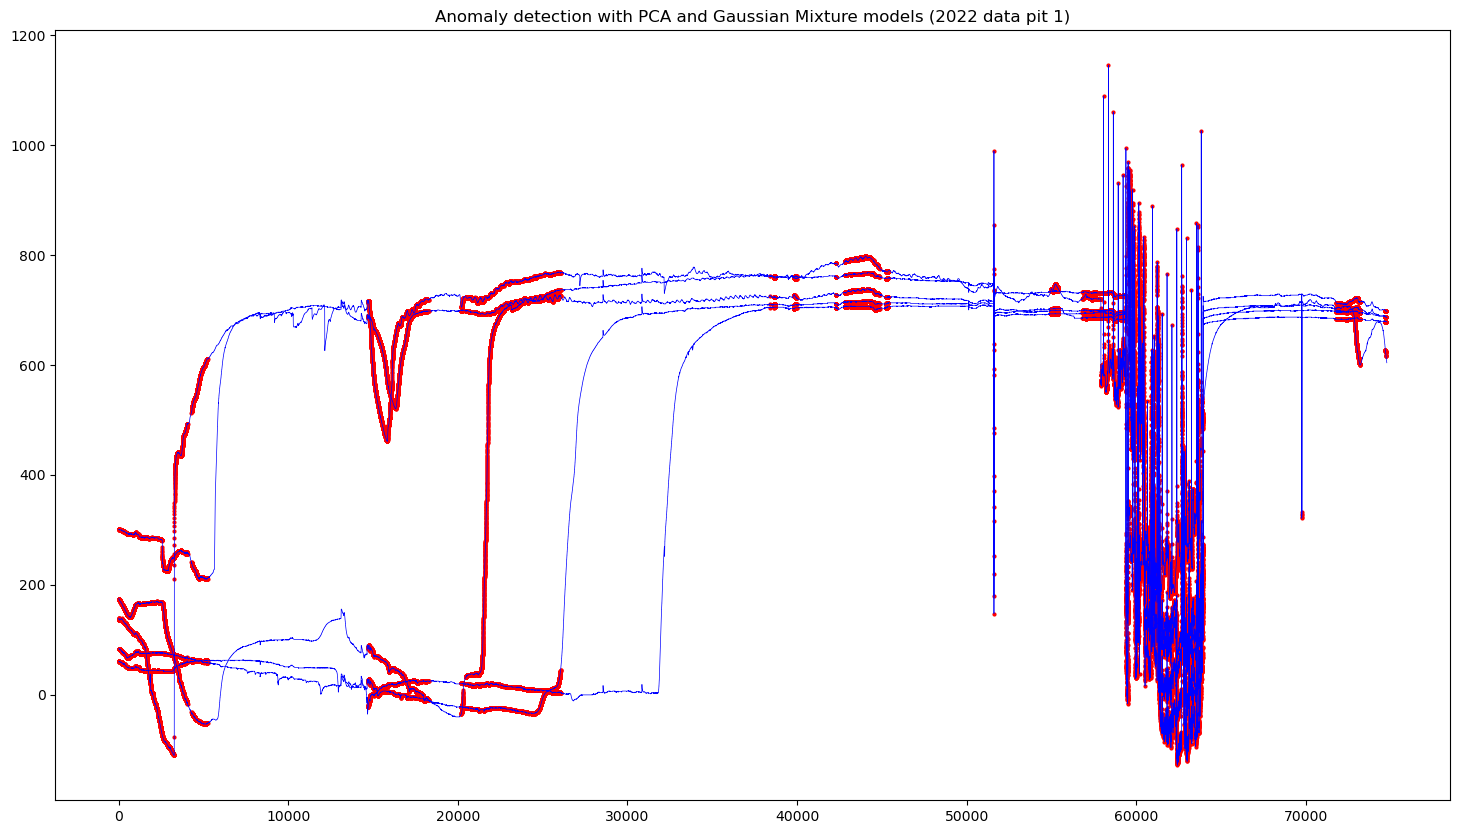

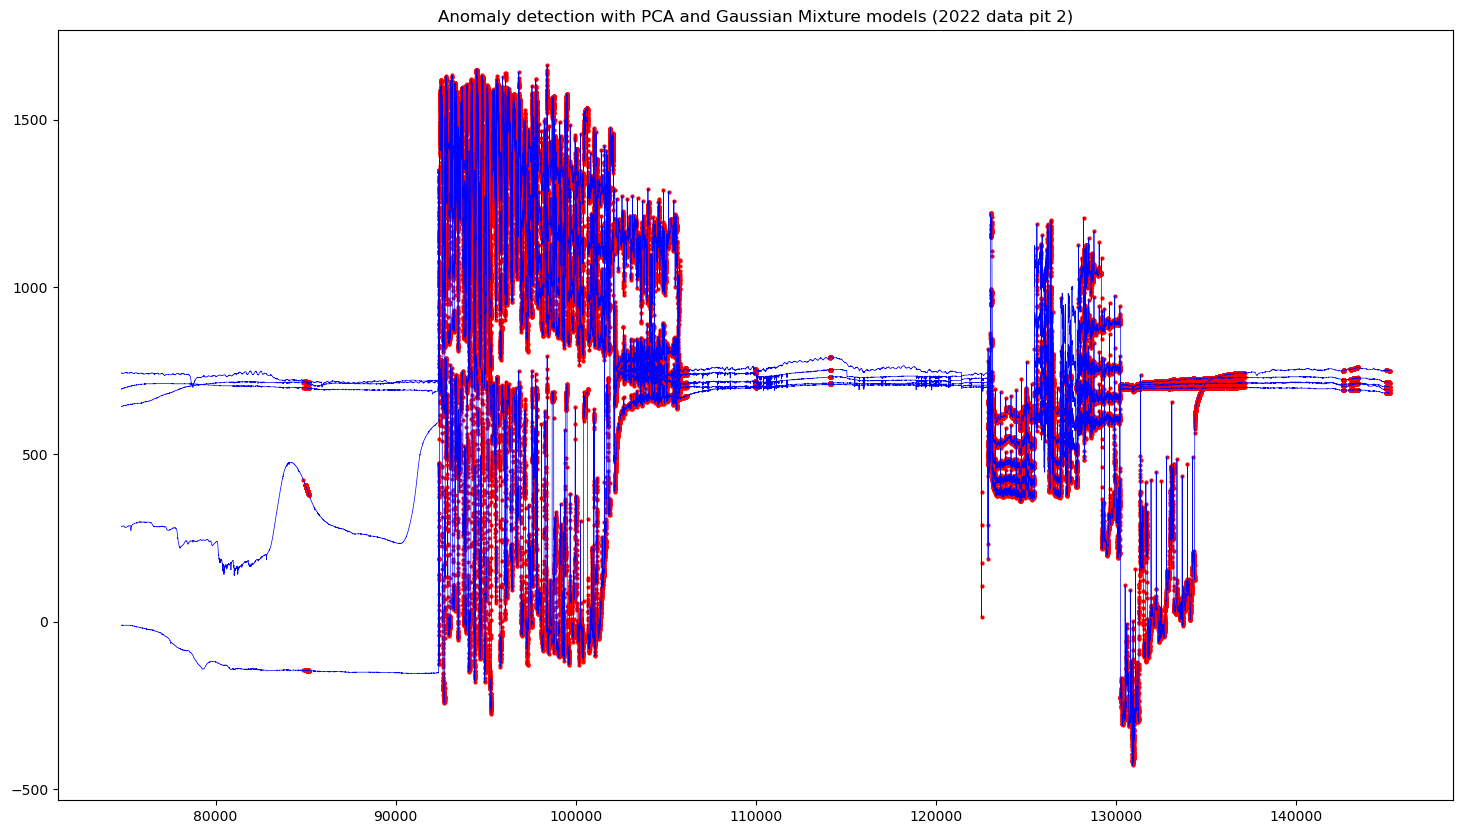

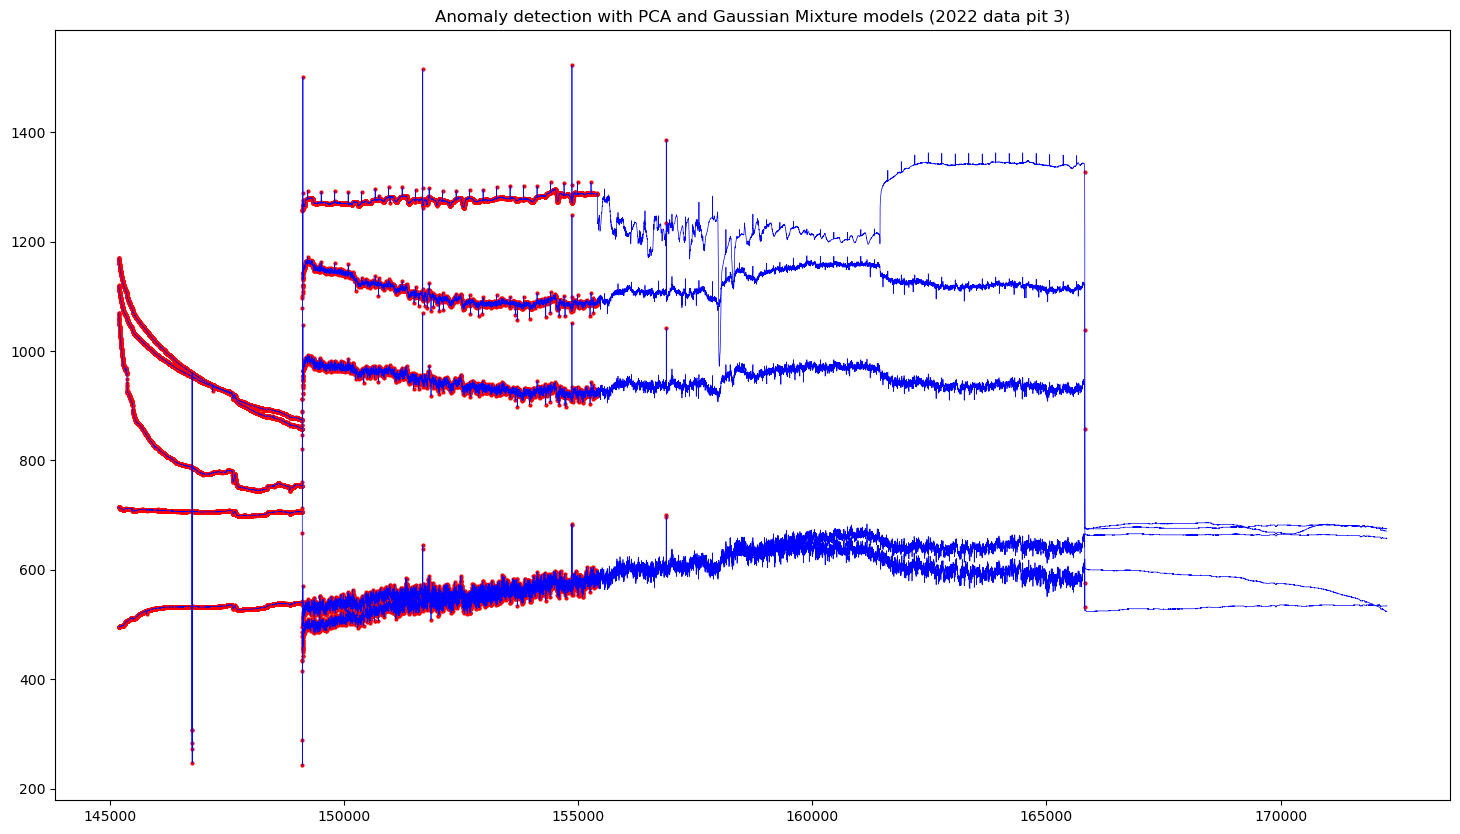

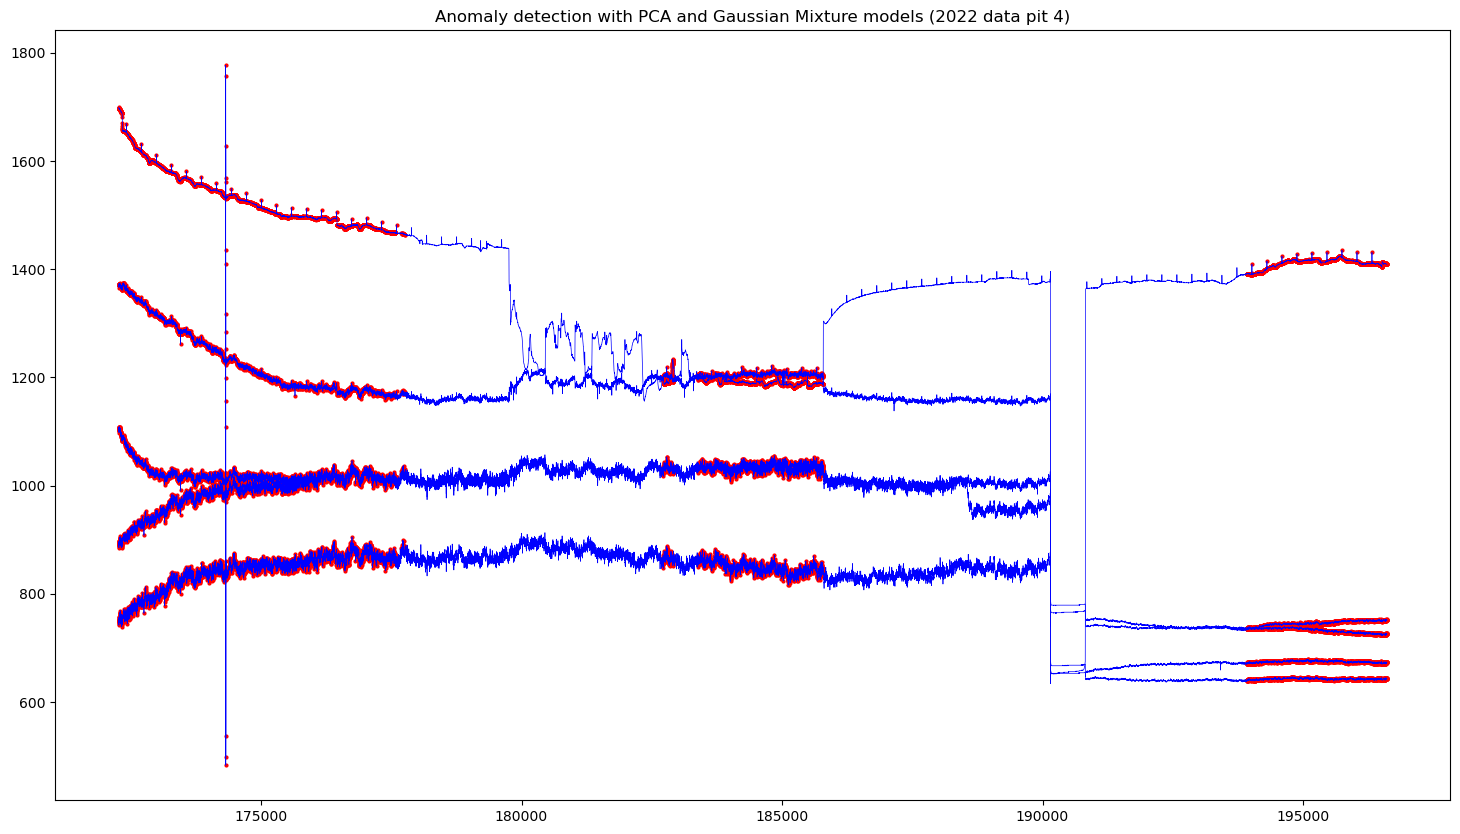

In [13]:
n_clusters = 3
pca_components = 5
outliers_fraction = 0.37
random_state = 10
pca_data = filter_pca_data(training_data_2022)
pca_scores = get_pca_scores(pca_data, pca_components)

anomaly_data = pca_gmix(pca_scores, training_data_2022, n_clusters, pca_components, outliers_fraction, random_state)
true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)
acc, prec, rec = get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives))
print(f'Components: {pca_components}, clusters: {n_clusters}, acc: {acc}, precision: {prec}, recall: {rec}')

plt.figure(figsize=(18,10))
plt.plot(anomaly_data.index, anomaly_data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5)
plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
plt.title('Anomaly detection with PCA and Gaussian Mixture models (2022 data)')
plt.legend(loc=(0.86,0.2))

for p in range(1,5):
    data = anomaly_data[anomaly_data['pit_number'] == p]
    plt.figure(figsize=(18,10))
    plt.plot(data.index, data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5, c='blue')
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(1)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(2)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(3)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(4)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(5)'], c='red', s=4)
    plt.title(f'Anomaly detection with PCA and Gaussian Mixture models (2022 data pit {p})')

In [14]:
outliers_fraction = 0.37
pca_data = filter_pca_data(training_data_2022)
pca_scores = get_pca_scores(pca_data, pca_components)

for components in range(4,8):
    for clusters in range(2,8):
        anomaly_data = pca_gmix(pca_scores, training_data_2022, clusters, components, outliers_fraction, random_state=10)
        acc, prec, rec = get_acc_metrics(get_acc_metric_dfs(anomaly_data))
        print(f'Components: {components}, clusters: {clusters}, acc: {acc}, precision: {prec}, recall: {rec}')

Components: 4, clusters: 2, acc: 0.5727255619020493, precision: 0.43139734689669396, recall: 0.42393785883147583
Components: 4, clusters: 3, acc: 0.5514854355599185, precision: 0.40269434325383185, recall: 0.3957311719013847
Components: 4, clusters: 4, acc: 0.5952270750576016, precision: 0.46180493504708225, recall: 0.45381965552178316
Components: 4, clusters: 5, acc: 0.608522498970037, precision: 0.47977180562237953, recall: 0.4714758527524485
Components: 4, clusters: 6, acc: 0.6073628368996333, precision: 0.4782046876073957, recall: 0.469935832489024
Components: 4, clusters: 7, acc: 0.6072712846309172, precision: 0.4780809677641075, recall: 0.4698142519419115
Components: 5, clusters: 2, acc: 0.5938334460782568, precision: 0.4599216440992508, recall: 0.4519689294157379
Components: 5, clusters: 3, acc: 0.7496248900101216, precision: 0.6704515774280019, recall: 0.6588584937521108
Components: 5, clusters: 4, acc: 0.6377785350619758, precision: 0.5193071688775861, recall: 0.51032759202971

## 2022 per pit

Pit: 1, components: 5, clusters: 5, acc: 0.939787074684357, precision: 0.6027287319422151, recall: 0.7462736005299768
Pit: 2, components: 5, clusters: 5, acc: 0.7309155969555833, precision: 0.9105367793240556, recall: 0.25925925925925924
Pit: 3, components: 5, clusters: 5, acc: 0.3454478301015697, precision: 0.8433690432212781, recall: 0.11659261529033246
Pit: 4, components: 5, clusters: 5, acc: 0.10327828444663545, precision: 0.8792111750205424, recall: 0.09039452563994255


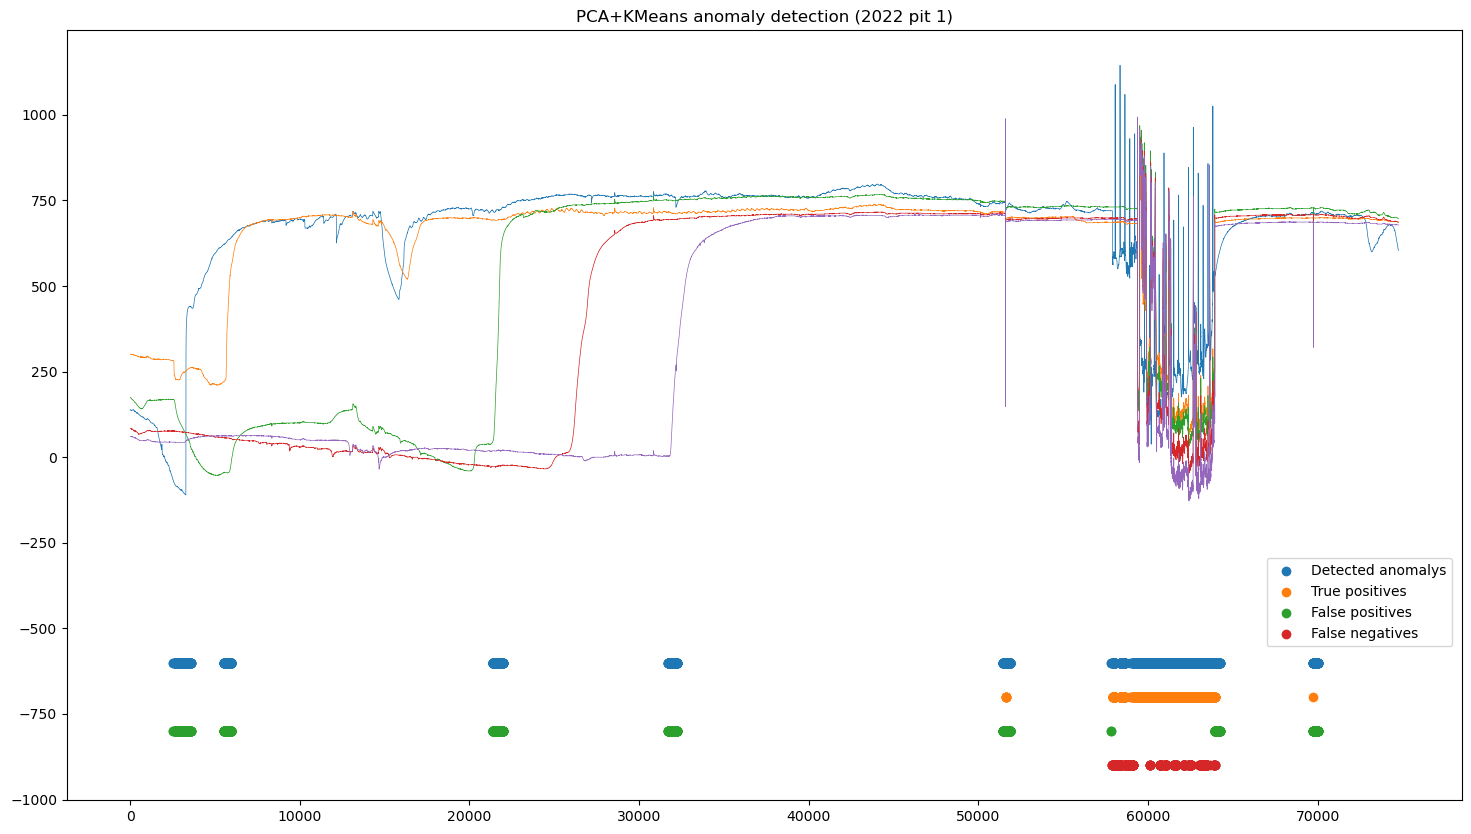

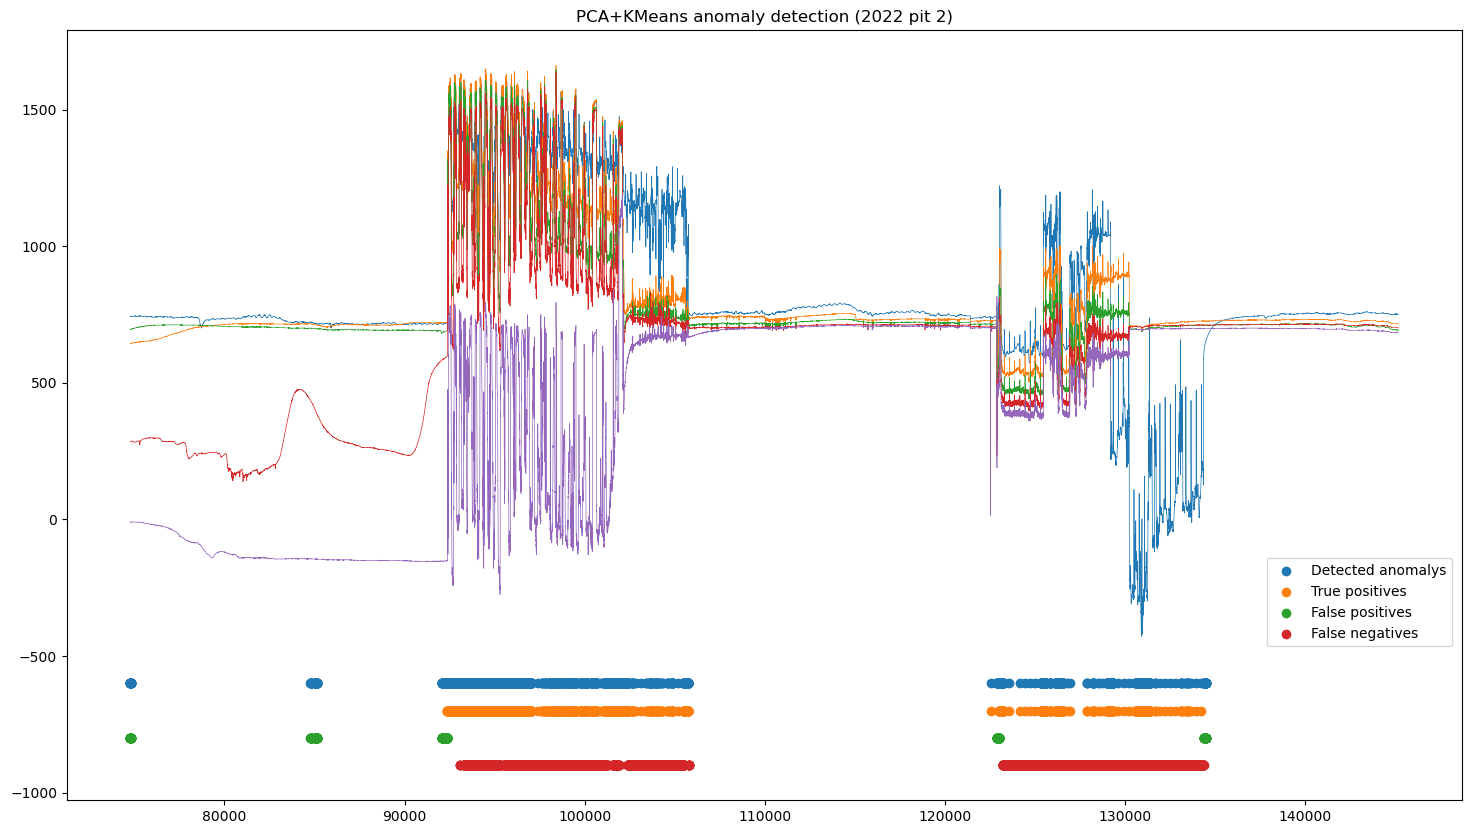

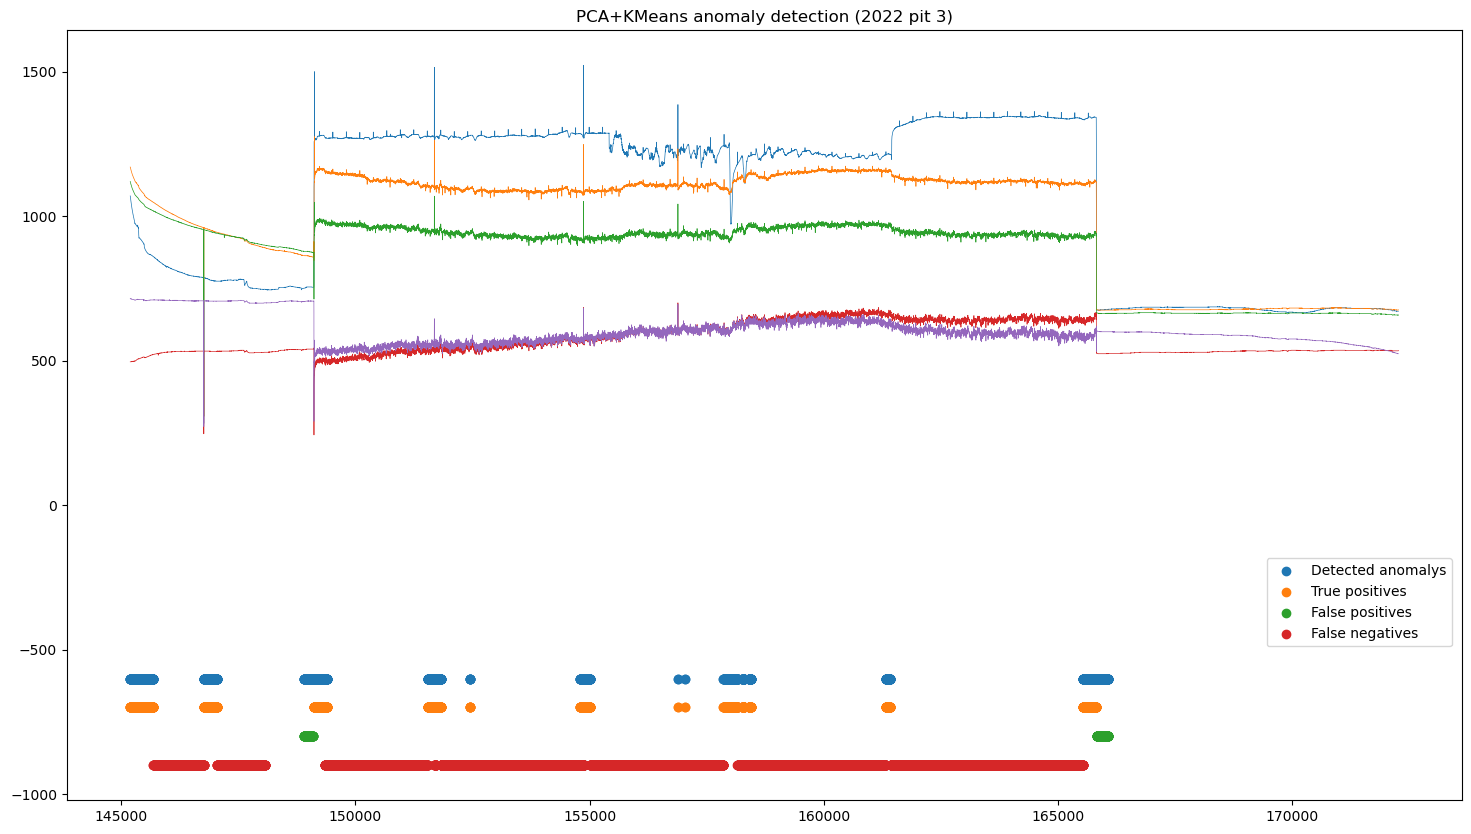

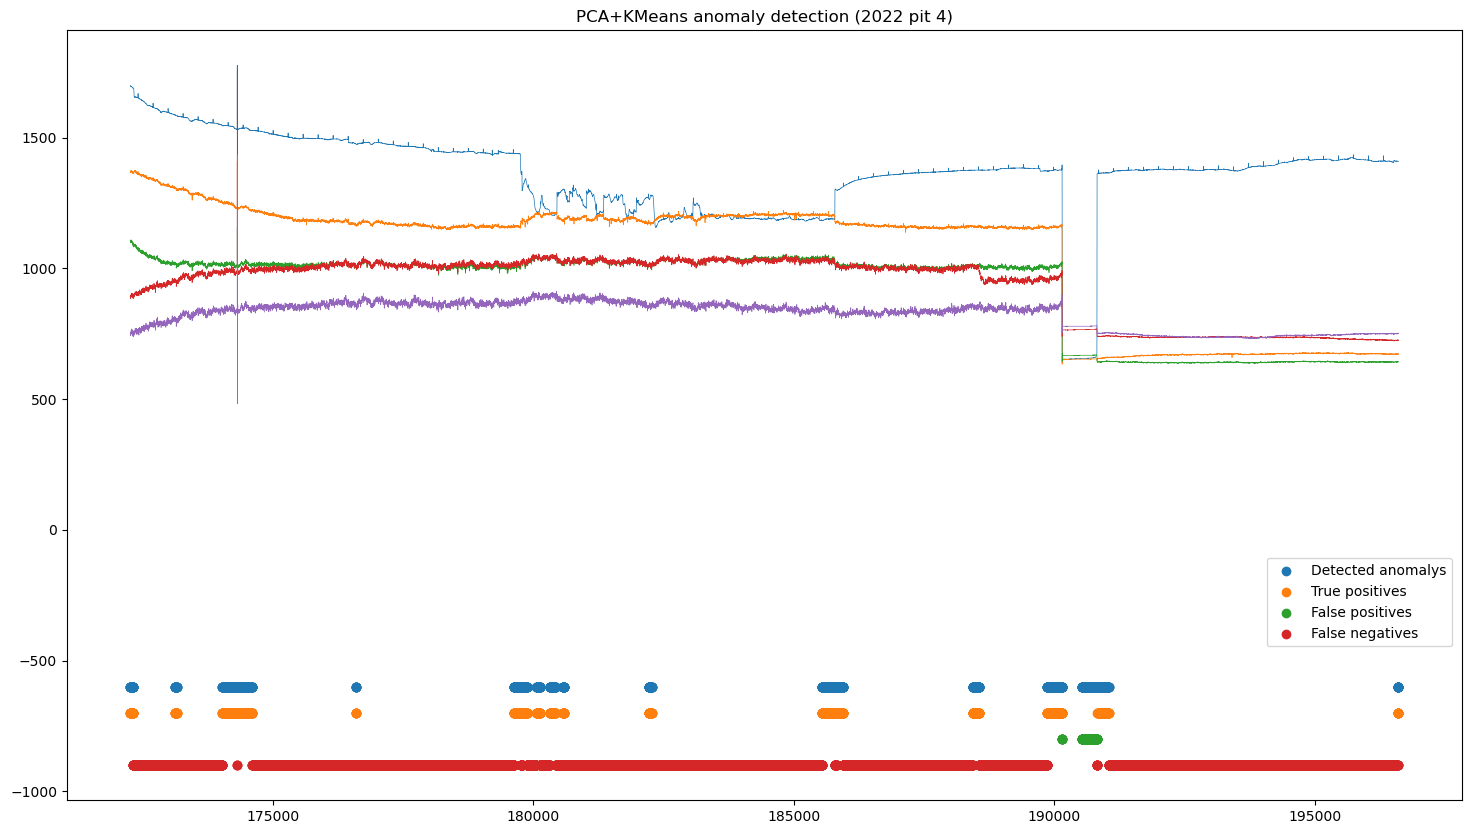

In [7]:
for pit in range(1,5):
    data = training_data_2022[training_data_2022['pit_number'] == pit]
    n_clusters = 5
    pca_components = 5
    outliers_fraction = 0.10
    pca_data = filter_pca_data(data)
    pca_scores = get_pca_scores(pca_data, pca_components)

    anomaly_data = pca_gmix(pca_scores, data, n_clusters, pca_components, outliers_fraction, 10)
    true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)
    acc, prec, rec = get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives))
    print(f'Pit: {pit}, components: {pca_components}, clusters: {n_clusters}, acc: {acc}, precision: {prec}, recall: {rec}')

    plt.figure(figsize=(18,10))
    plt.plot(anomaly_data.index, anomaly_data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5)
    plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
    plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
    plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
    plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
    plt.legend(loc=(0.86,0.2))
    plt.title(f'PCA+KMeans anomaly detection (2022 pit {pit})')

(0.6920079955648012, 0.77706002034588, 0.2138198410032471)
(0.7672741329237217, 0.871973550356053, 0.283909111987016)
(0.7632610918116668, 0.8565106815869786, 0.278041048164721)
(0.8593553703034957, 0.8373346897253306, 0.4023364942809659)
(0.9064793575065231, 0.6235503560528993, 0.5273822327382233)


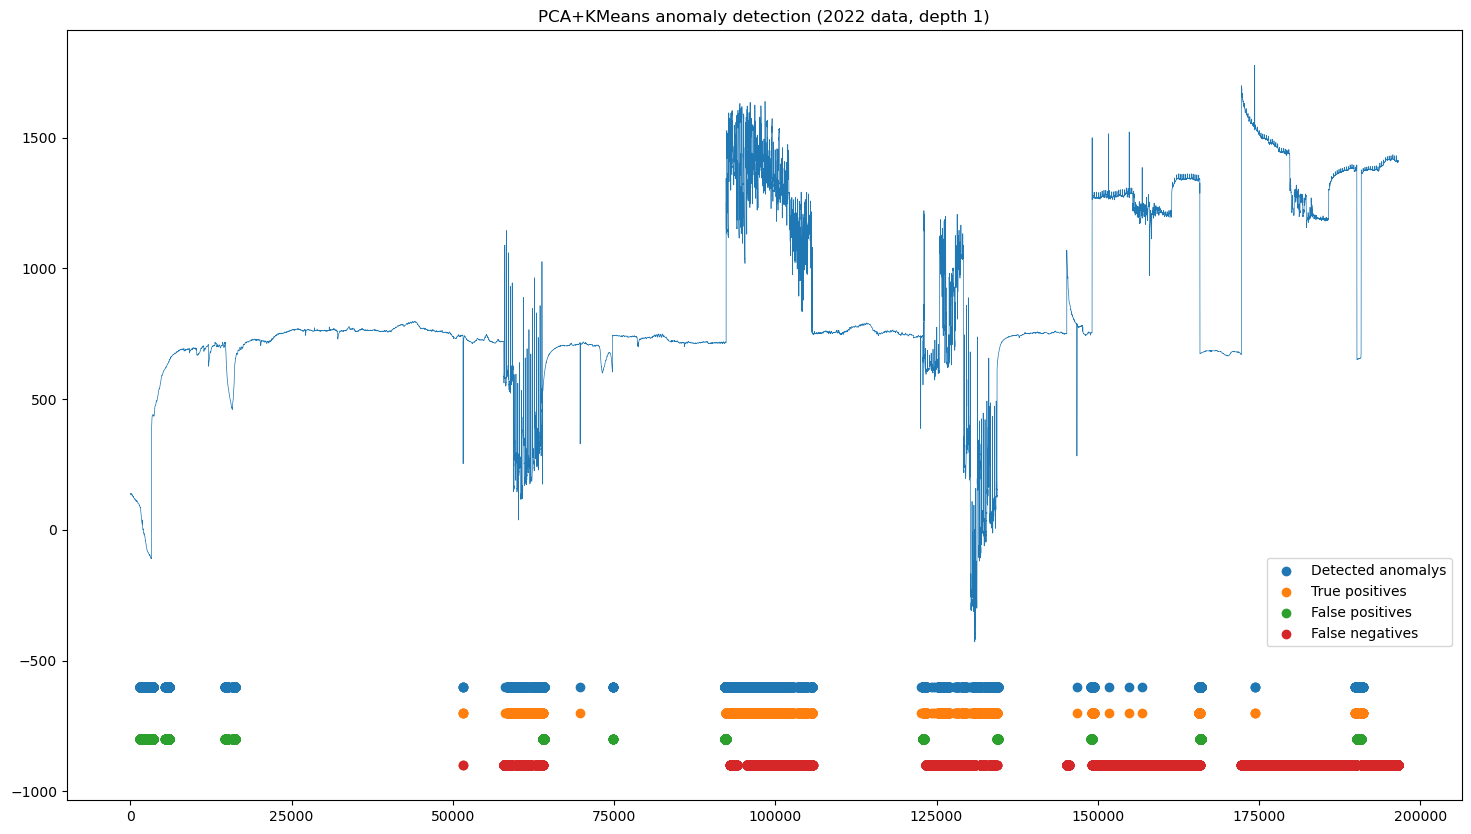

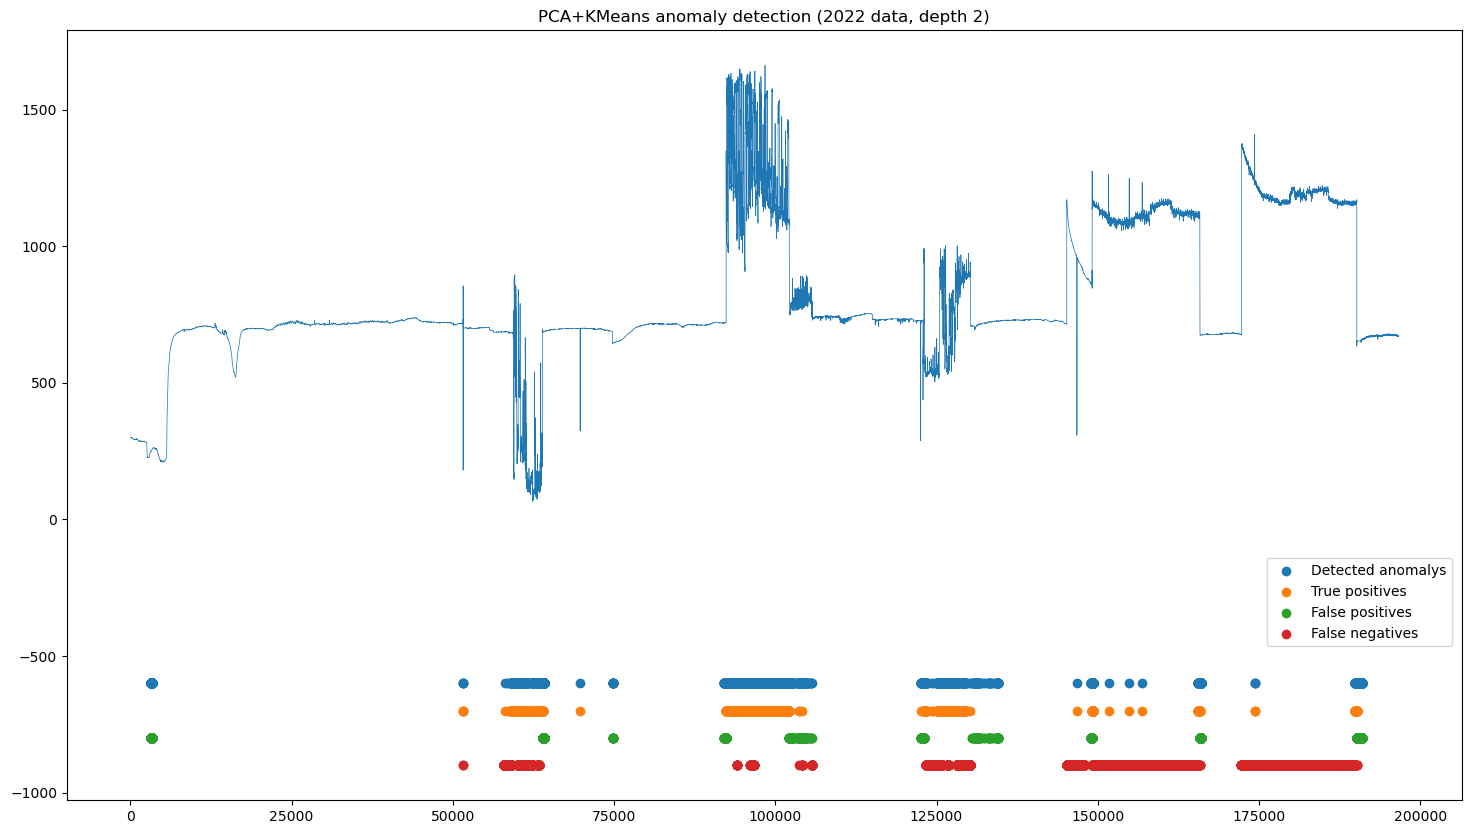

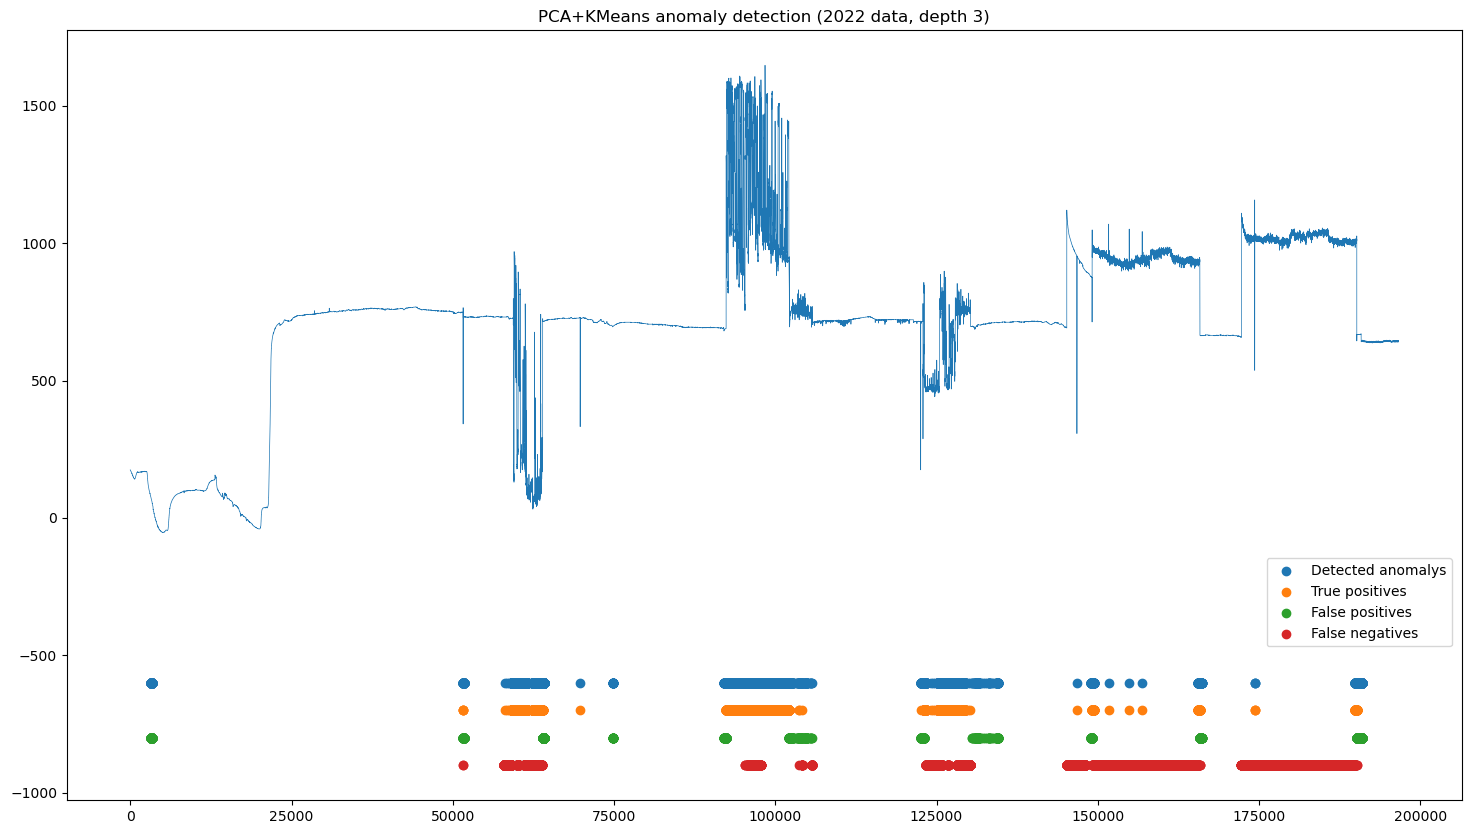

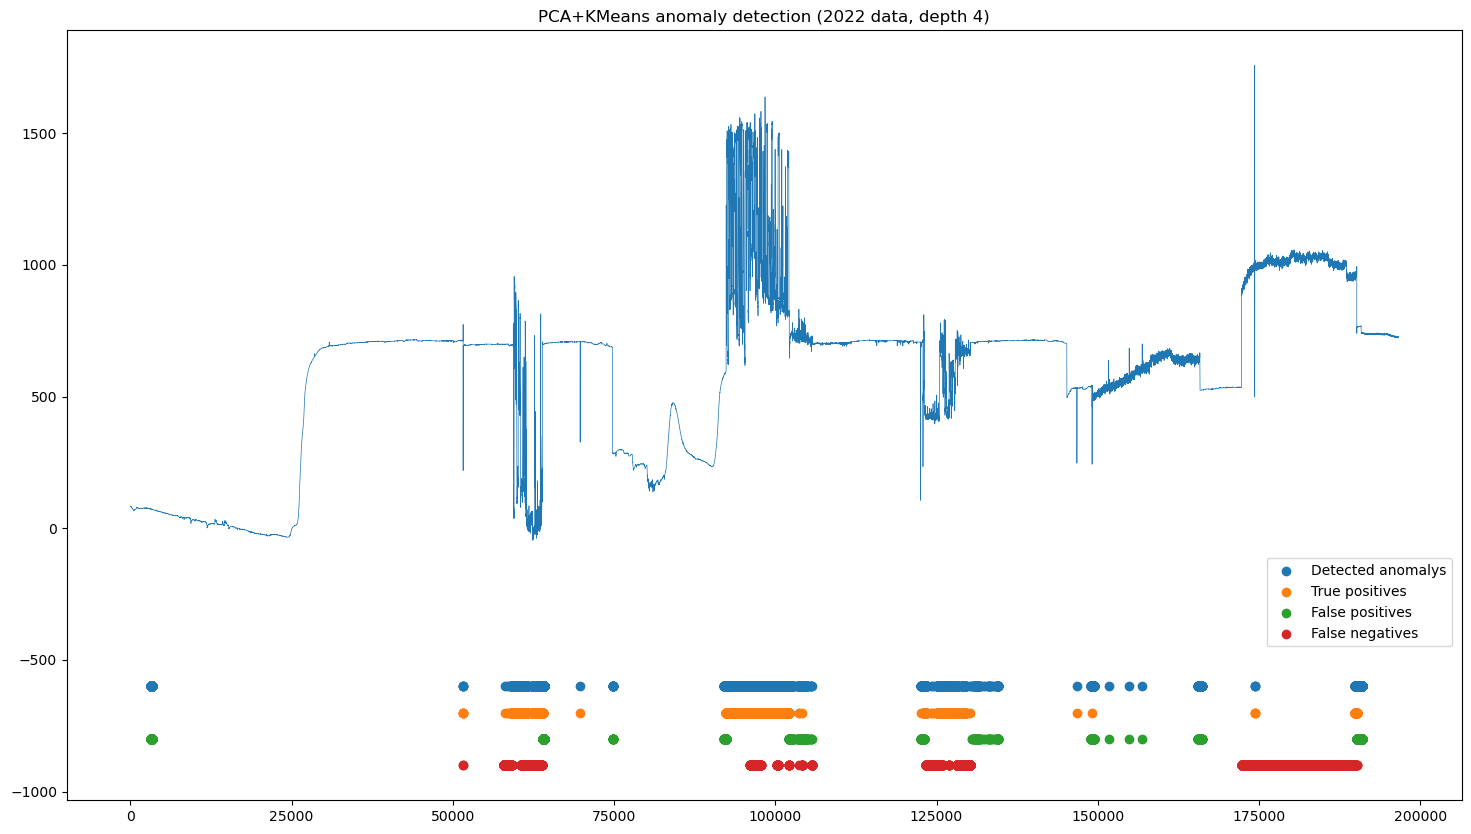

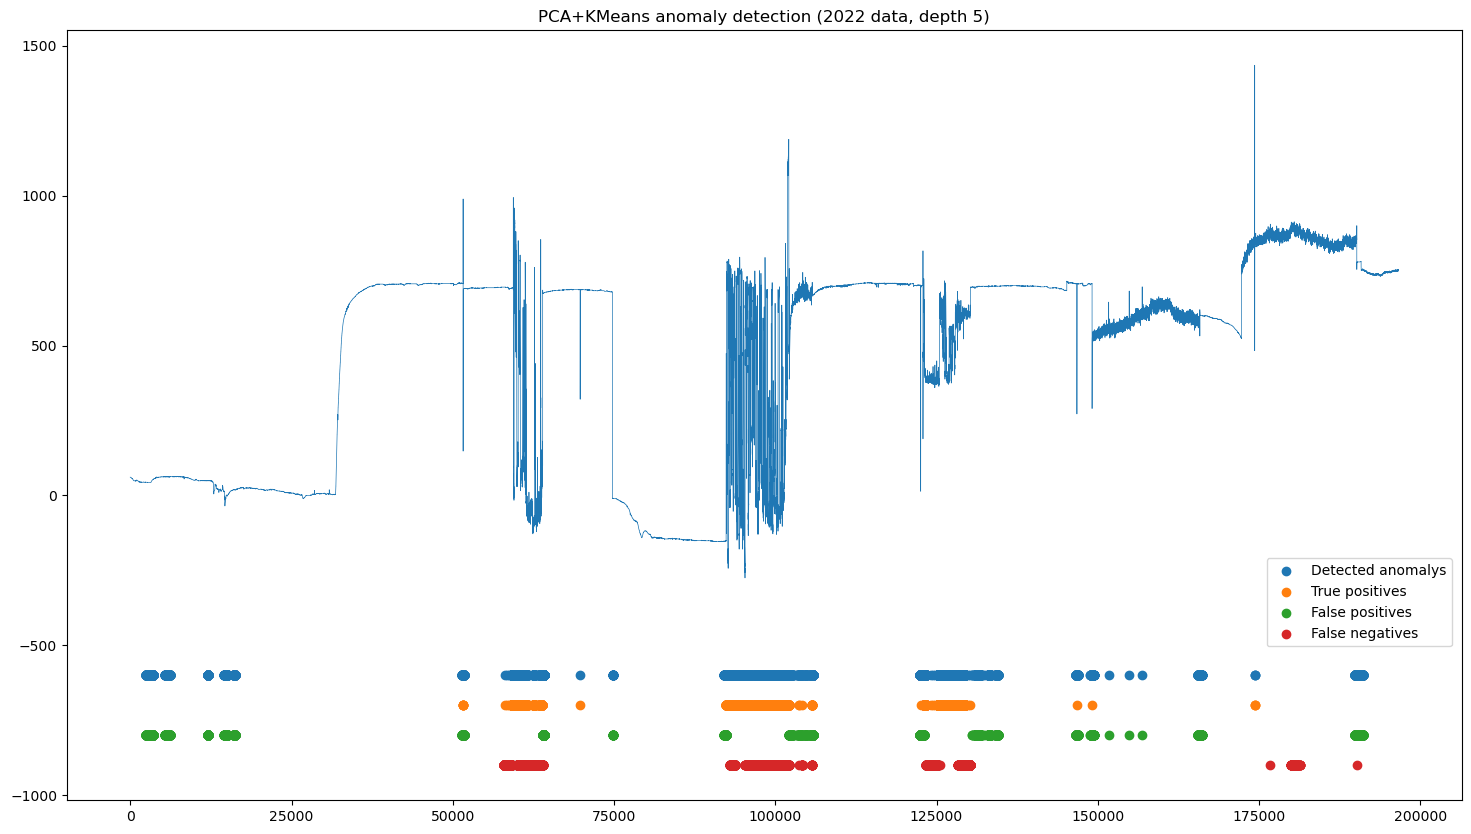

In [8]:
n_clusters = 3
pca_components = 5
outliers_fraction = 0.10
random_state = 10

for d in range(1,6):
    depths = [1,2,3,4,5]
    depths.remove(d)
    pca_data = filter_pca_data(training_data_2022, depths)
    pca_scores = get_pca_scores(pca_data, pca_components)

    anomaly_data = pca_gmix(pca_scores, training_data_2022, n_clusters, pca_components, outliers_fraction, random_state)
    true_positives, true_negatives, false_positives, false_negatives = get_ind_depth_acc_metric_dfs(anomaly_data, d)
    print(get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives)))

    plt.figure(figsize=(18,10))
    plt.plot(anomaly_data.index, anomaly_data[[f'Redox_Avg({d})']], linewidth=0.5)
    plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
    plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
    plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
    plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
    plt.title(f'PCA+KMeans anomaly detection (2022 data, depth {d})')
    plt.legend(loc=(0.86,0.2))

In [9]:
n_clusters = 5
outliers_fraction = 0.10
pca_components = 6
random_state = 10

for pit in range(1,5):
   data = training_data_2022[training_data_2022['pit_number'] == pit]
   pca_data = filter_pca_data(data)
   for d in range(1,6):
      depths = [1,2,3,4,5]
      depths.remove(d)
      pca_data = filter_pca_data(data, depths)
      pca_scores = get_pca_scores(pca_data, pca_components)

      anomaly_data = pca_gmix(pca_scores, data, n_clusters, pca_components, outliers_fraction, random_state)
      true_positives, true_negatives, false_positives, false_negatives = get_ind_depth_acc_metric_dfs(anomaly_data, d)
      acc, prec, rec = get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives))
      print(f'Pit: {pit}, depth: {d}, acc: {acc}, precision: {prec}, recall: {rec}')

Pit: 1, depth: 1, acc: 0.9529477851487267, precision: 0.6685393258426966, recall: 0.8277575356078172
Pit: 1, depth: 2, acc: 0.9180398031243313, precision: 0.49398073836276085, recall: 0.6116263663464724
Pit: 1, depth: 3, acc: 0.9102289749625508, precision: 0.45492241840556447, recall: 0.5632659821132825
Pit: 1, depth: 4, acc: 0.9393858335116627, precision: 0.6007223113964687, recall: 0.7437893342166281
Pit: 1, depth: 5, acc: 0.9344104429702547, precision: 0.5758426966292135, recall: 0.7129844319311031
Pit: 2, depth: 1, acc: 0.7296092241281381, precision: 0.9040045441635899, recall: 0.257399320718098
Pit: 2, depth: 2, acc: 0.8065432239009429, precision: 0.7452428287418347, recall: 0.3072959362923059
Pit: 2, depth: 3, acc: 0.8202033397705327, precision: 0.8125532519170691, recall: 0.3353258321612752
Pit: 2, depth: 4, acc: 0.823298875383392, precision: 0.8280318091451292, recall: 0.34171354899203
Pit: 2, depth: 5, acc: 0.8061740315801431, precision: 0.742402726498154, recall: 0.3063759962

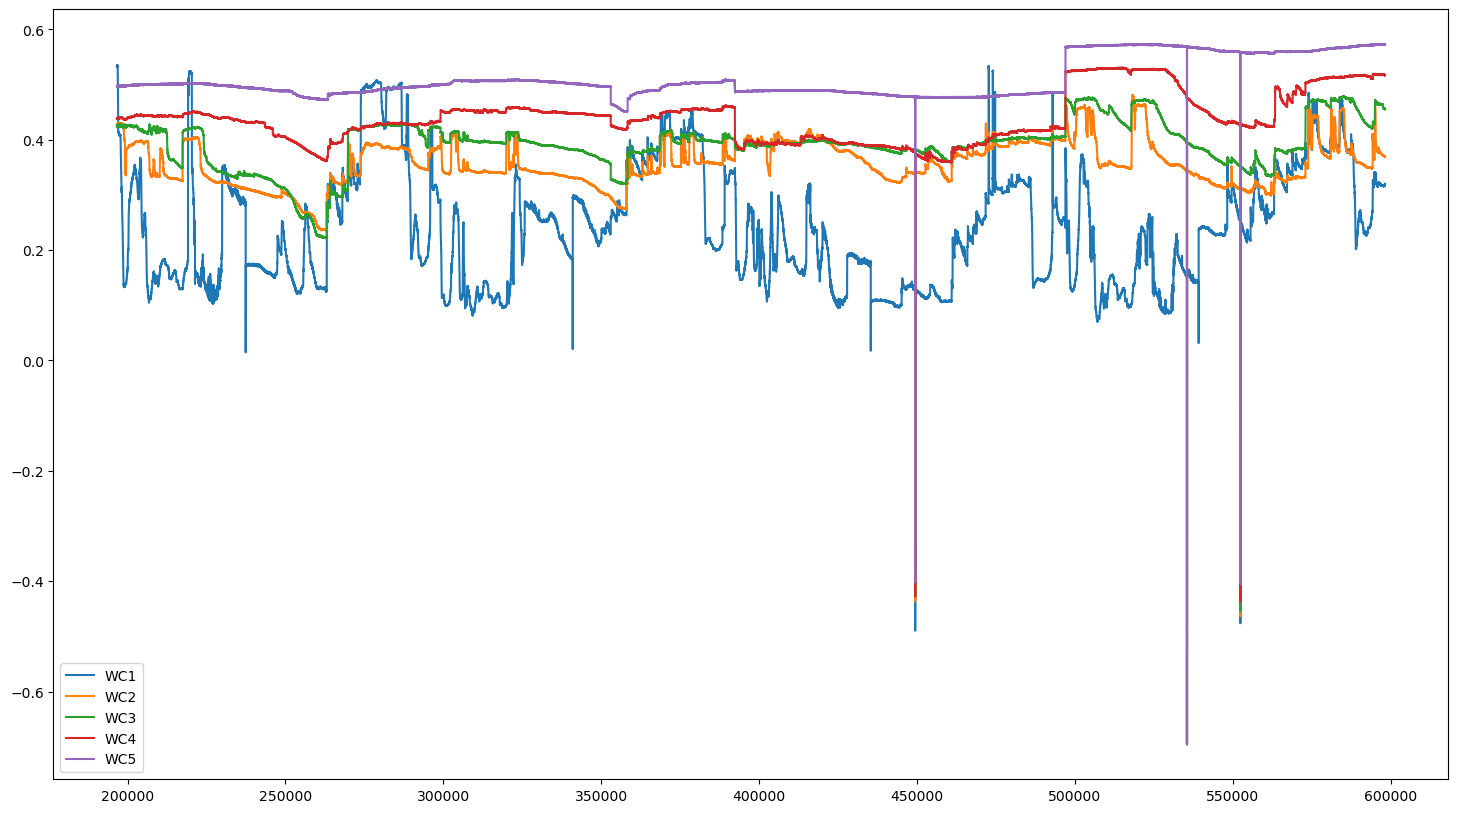

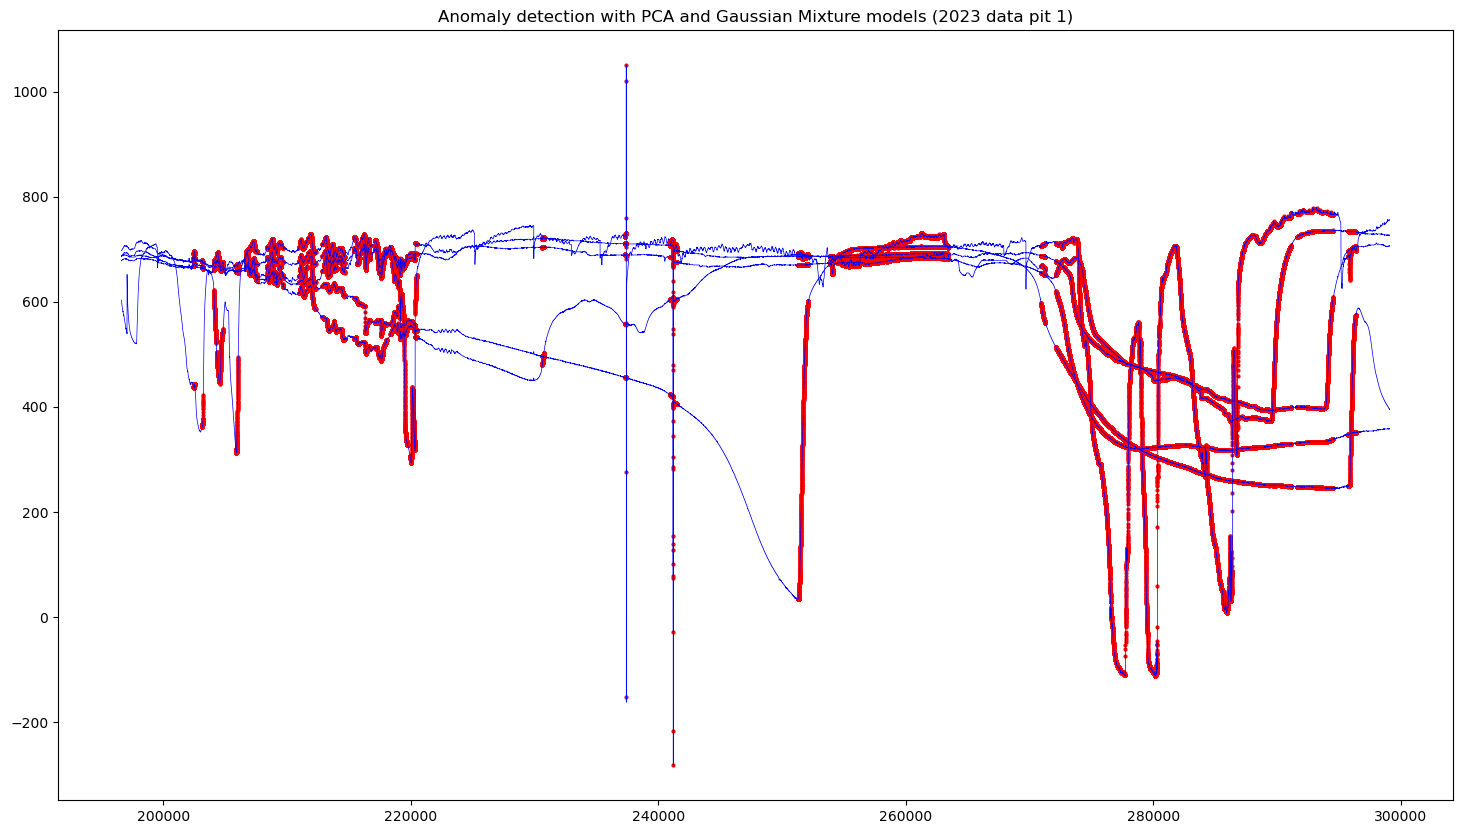

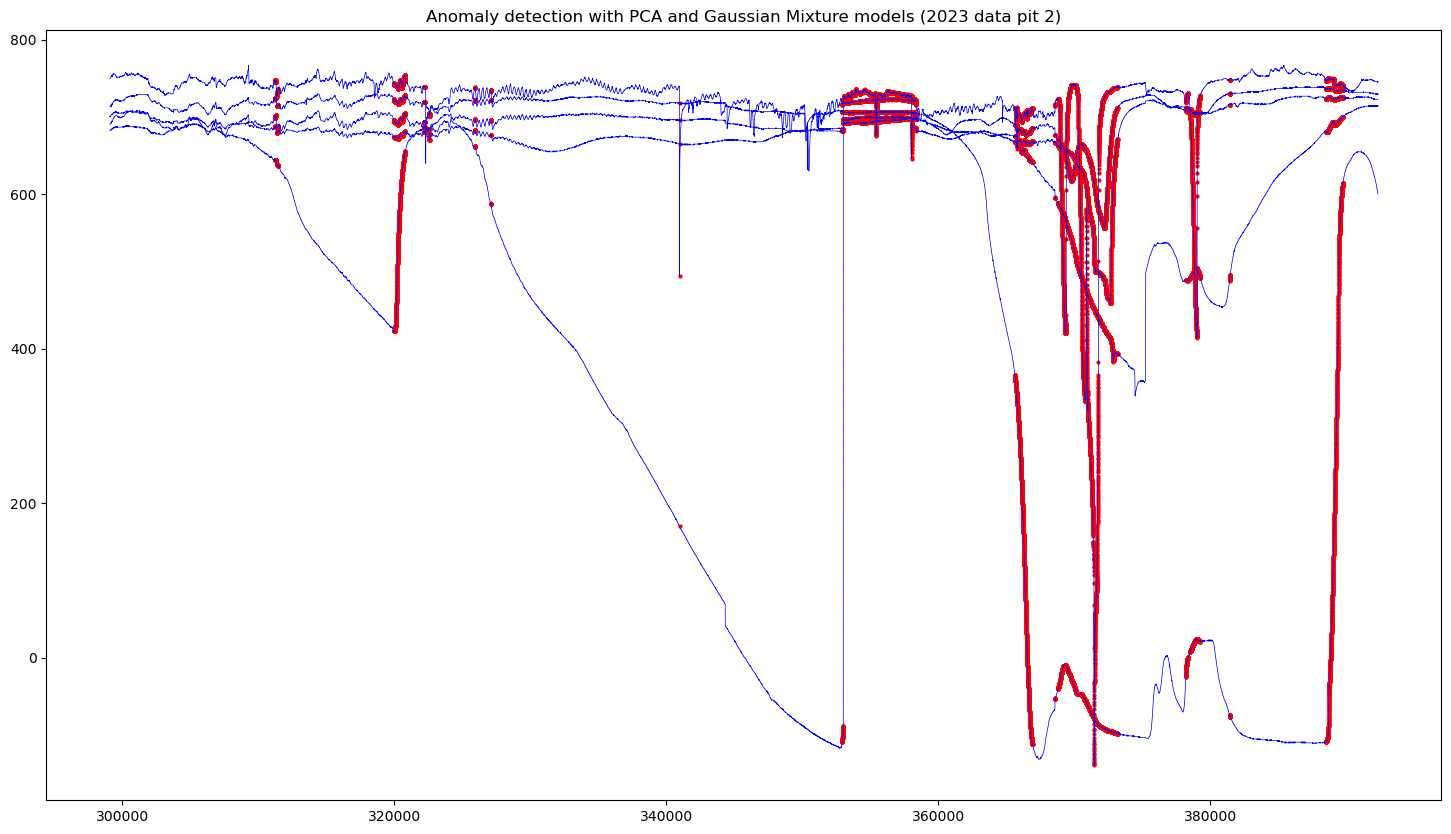

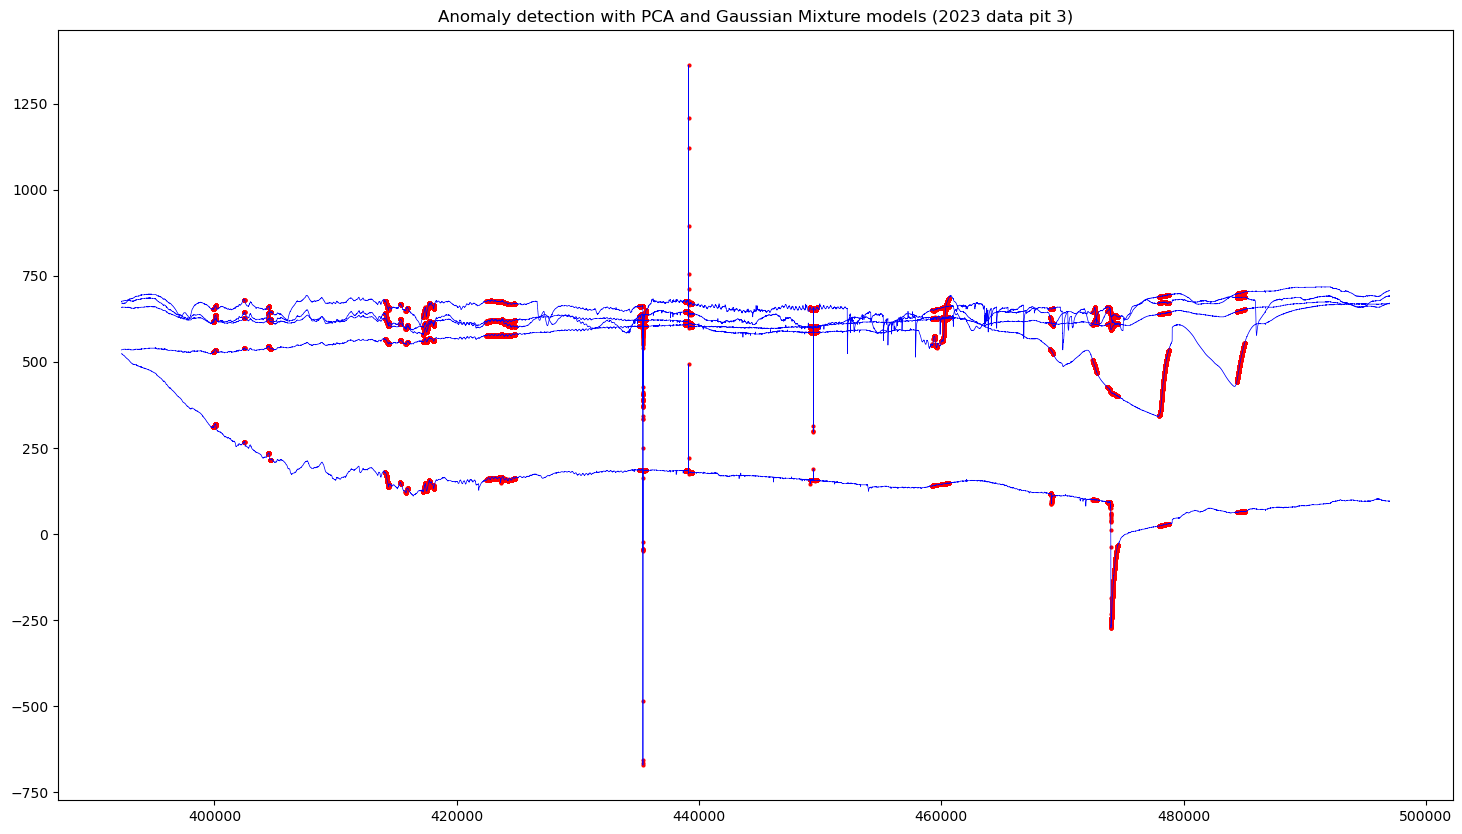

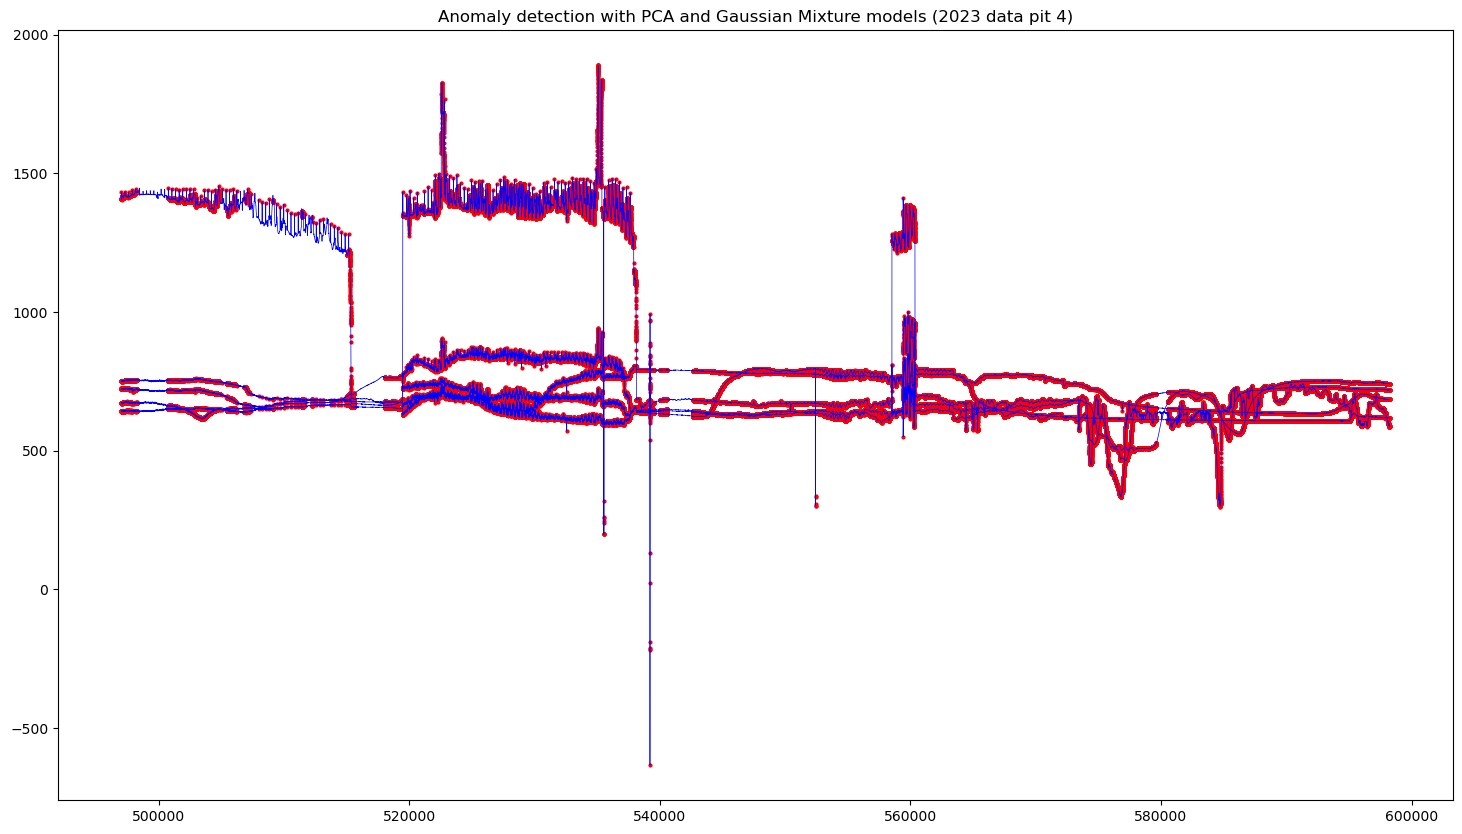

In [10]:
n_clusters = 3
pca_components = 5
outliers_fraction = 0.37
random_state = 10

pca_data = filter_pca_data(training_data_2023)
pca_scores = get_pca_scores(pca_data, pca_components)
anomaly_data = pca_gmix(pca_scores, training_data_2023, n_clusters, pca_components, outliers_fraction, random_state)
true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)

plt.figure(figsize=(18,10))
plt.plot(anomaly_data.index, anomaly_data[['WC1', 'WC2', 'WC3', 'WC4', 'WC5']], label=['WC1', 'WC2', 'WC3', 'WC4', 'WC5'])
plt.legend()

for p in range(1,5):
    data = anomaly_data[anomaly_data['pit_number'] == p]
    plt.figure(figsize=(18,10))
    plt.plot(data.index, data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5, c='blue')
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(1)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(2)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(3)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(4)'], c='red', s=4)
    plt.scatter(data[data['anomaly'] == True].index, data[data['anomaly'] == True]['Redox_Avg(5)'], c='red', s=4)
    plt.title(f'Anomaly detection with PCA and Gaussian Mixture models (2023 data pit {p})')